Business Goal:  Identify which customer regions generate the highest total sales for each product category, month-by-month.

Set up the notebook

In [36]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px


ModuleNotFoundError: No module named 'plotly'

Connect to the SQLite Database

In [23]:
conn = sqlite3.connect(r"C:\Users\beths\Documents\Northwest_Missouri_Analytics\BI_Analytics\smart-store-bethspornitz\data\dw\smart_sales.db")

Preview Tables

In [24]:
# Check table names
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

       name
0  customer
1   product
2      sale


Write the OLAP Query
This query joins the three tables and aggregates total sales by region, category, and month:

In [25]:
query = """
SELECT 
    c.customer_region AS customer_region,
    p.product_category AS product_category,
    strftime('%Y-%m', s.purchase_date) AS sale_month,
    SUM(s.sale_amount_usd) AS total_sales
FROM sale s
JOIN customer c ON s.customer_id = c.customer_id
JOIN product p ON s.product_id = p.product_id
GROUP BY customer_region, product_category, sale_month
ORDER BY customer_region, product_category, sale_month;
"""

df_olap = pd.read_sql(query, conn)

Preview Results

In [26]:
df_olap.head()

,customer_region,product_category,sale_month,total_sales
0,East,Clothing,2024-02,1318.10
1,East,Clothing,2024-05,117.30
2,East,Clothing,2024-06,387.90
3,East,Clothing,2024-07,694.34
4,East,Clothing,2024-08,1263.90


Bar Plot: Total Sales by Region and Product Category


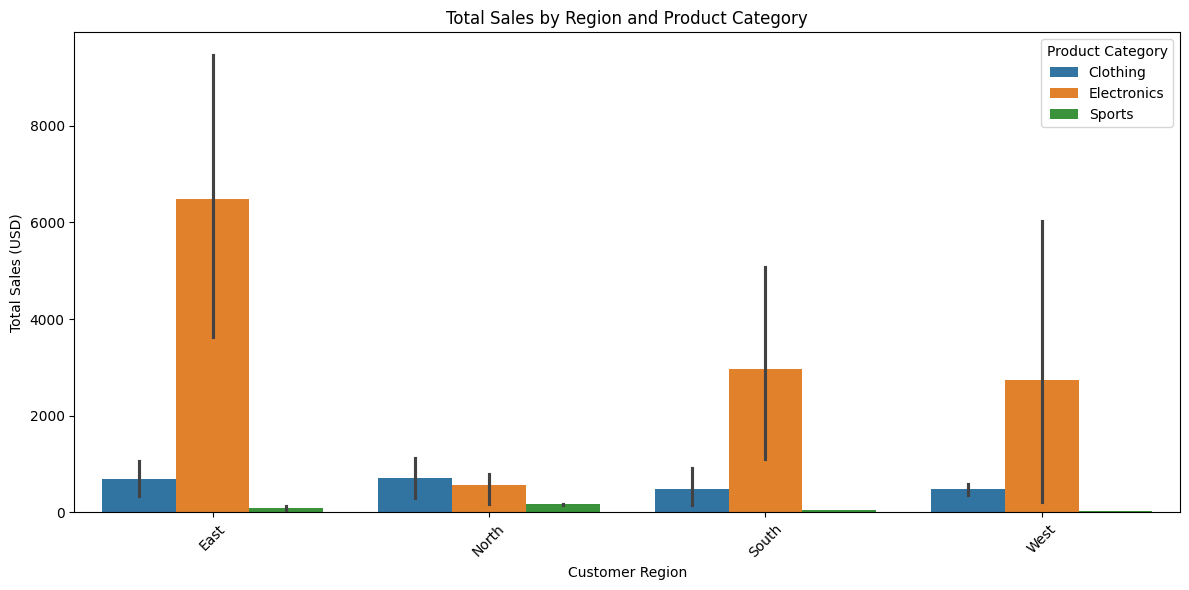

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_olap, x="customer_region", y="total_sales", hue="product_category")
plt.title("Total Sales by Region and Product Category")
plt.ylabel("Total Sales (USD)")
plt.xlabel("Customer Region")
plt.legend(title="Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Line Chart: Sales Trends by Month (Faceted by Region)

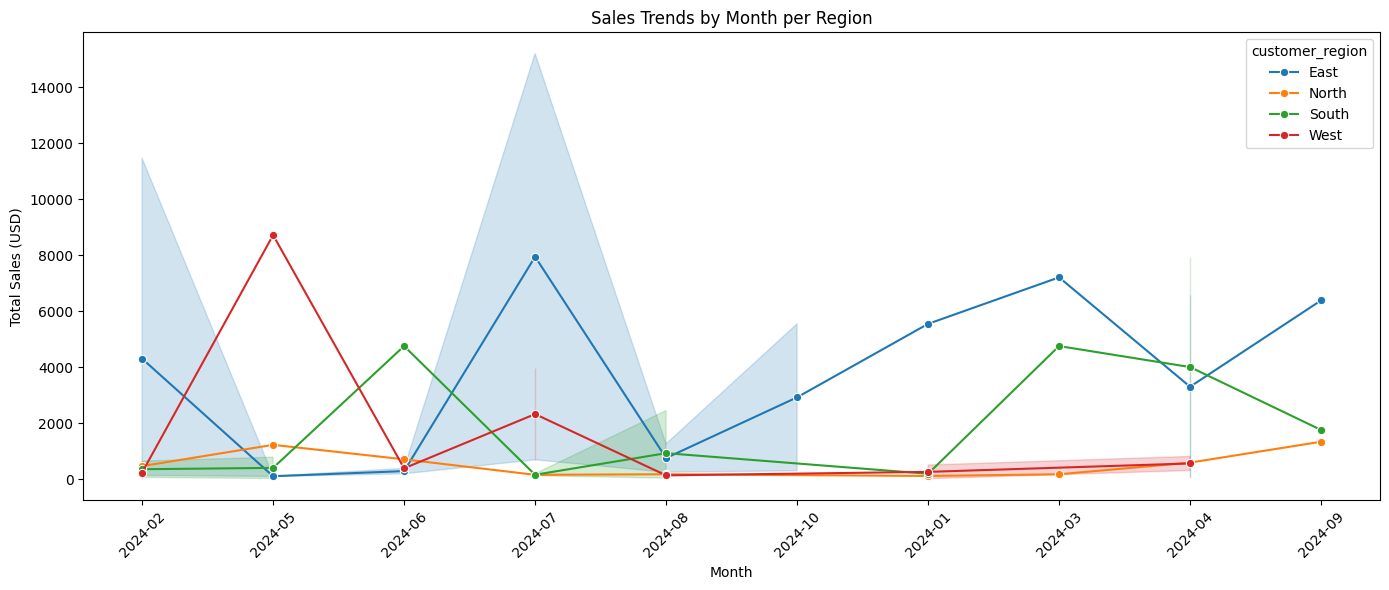

In [28]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_olap, x="sale_month", y="total_sales", hue="customer_region", marker='o')
plt.title("Sales Trends by Month per Region")
plt.ylabel("Total Sales (USD)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Heatmap: Region vs Product Category by Total Sales

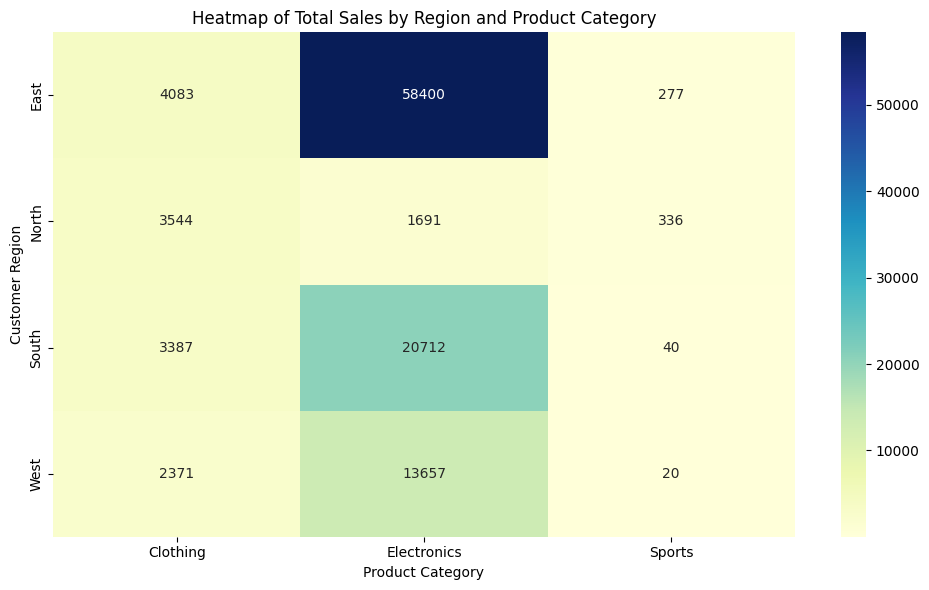

In [29]:
heatmap_data = df_olap.pivot_table(
    index="customer_region", 
    columns="product_category", 
    values="total_sales", 
    aggfunc="sum", 
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap of Total Sales by Region and Product Category")
plt.ylabel("Customer Region")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()